# Billboard Lexical Diversity Analysis (2000-2023)

How does lexical diversity relate to chart performance across genres?

## 1. Setup & Data Loading

In [76]:
# Libraries and setup
library(tidyverse)
library(ggplot2)
library(scales)
library(viridis)

options(scipen = 999)
theme_set(theme_minimal(base_size = 12))

# Color palette
genre_colors <- c(
  "POP" = "#FF6B6B",
  "HIP HOP" = "#4ECDC4",
  "COUNTRY" = "#FFD93D",
  "ROCK" = "#95E1D3",
  "R&B" = "#F38181",
  "ELECTRONIC" = "#AA96DA",
  "LATIN" = "#FCE77D",
  "OTHER" = "#C8C8C8"
)

In [77]:
# Load data
df <- read_csv('../../data/cleaned/billboard_lexical_analysis_ready.csv',
               show_col_types = FALSE)

df_analysis <- df %>%
  filter(has_complete_data == TRUE)

cat(sprintf("Total: %d songs, Analysis set: %d (%.1f%%)\n", 
            nrow(df), nrow(df_analysis), nrow(df_analysis)/nrow(df)*100))
cat(sprintf("Years: %d-%d, Genres: %d\n", 
            min(df$year), max(df$year), n_distinct(df_analysis$macro_genre)))

Total songs: 3427
Songs for analysis: 2822 (82.3%)
Years: 2000-2023
Genres: 8


## 2. Exploratory Analysis

In [78]:
# Summary stats by genre
summary_stats <- df_analysis %>%
  group_by(macro_genre) %>%
  summarise(
    n = n(),
    mean_ttr = mean(ttr, na.rm = TRUE),
    median_ttr = median(ttr, na.rm = TRUE),
    sd_ttr = sd(ttr, na.rm = TRUE),
    mean_lexical_density = mean(lexical_density, na.rm = TRUE),
    mean_rare_word_ratio = mean(rare_word_ratio, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(mean_ttr))

print(summary_stats)

# A tibble: 8 x 8
  macro_genre     n mean_ttr median_ttr sd_ttr mean_lexical_density
  <chr>       <int>    <dbl>      <dbl>  <dbl>                <dbl>
1 COUNTRY       267    0.354      0.349 0.0695                0.357
2 LATIN          51    0.349      0.361 0.0735                0.605
3 HIP HOP       706    0.330      0.323 0.0763                0.396
4 ROCK          166    0.314      0.314 0.0598                0.324
5 R&B           107    0.307      0.305 0.0782                0.329
6 OTHER         134    0.307      0.300 0.0898                0.394
7 POP          1333    0.292      0.279 0.0881                0.367
8 ELECTRONIC     58    0.279      0.263 0.101                 0.363
# i 2 more variables: mean_rare_word_ratio <dbl>, mean_jaccard_common <dbl>


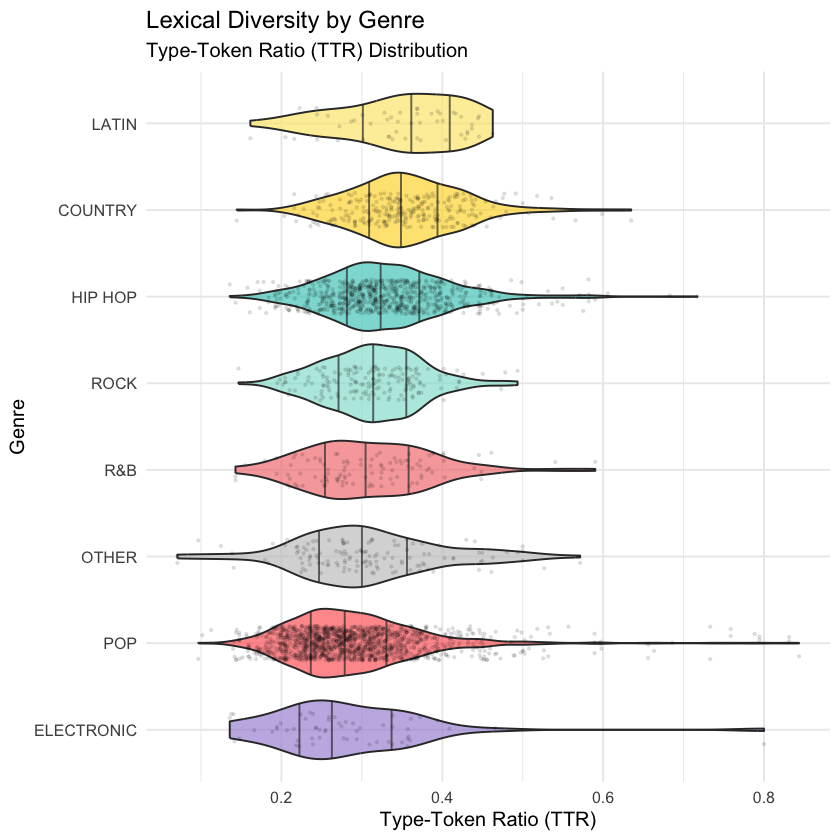

In [79]:
# TTR by genre
ggplot(df_analysis, aes(x = reorder(macro_genre, ttr, median), 
                        y = ttr, 
                        fill = macro_genre)) +
  geom_violin(alpha = 0.7, draw_quantiles = c(0.25, 0.5, 0.75)) +
  geom_jitter(alpha = 0.1, width = 0.2, size = 0.5) +
  scale_fill_manual(values = genre_colors) +
  labs(title = "TTR Distribution by Genre", x = "Genre", y = "TTR") +
  coord_flip() +
  theme(legend.position = "none")

## 3. Genre Comparison

In [80]:
# ANOVA: TTR across genres
anova_ttr <- aov(ttr ~ macro_genre, data = df_analysis)
summary(anova_ttr)
TukeyHSD(anova_ttr)

              Df Sum Sq Mean Sq F value              Pr(>F)    
macro_genre    7  1.365 0.19493   29.04 <0.0000000000000002 ***
Residuals   2814 18.891 0.00671                                
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = ttr ~ macro_genre, data = df_analysis)

$macro_genre
                            diff           lwr            upr     p adj
ELECTRONIC-COUNTRY -0.0747711895 -0.1107740488 -0.03876833025 0.0000000
HIP HOP-COUNTRY    -0.0240900655 -0.0419452104 -0.00623492066 0.0011403
LATIN-COUNTRY      -0.0048636702 -0.0428421679  0.03311482747 0.9999383
OTHER-COUNTRY      -0.0475196969 -0.0738301966 -0.02120919724 0.0000013
POP-COUNTRY        -0.0619814739 -0.0786445135 -0.04531843432 0.0000000
R&B-COUNTRY        -0.0474070595 -0.0758420588 -0.01897206022 0.0000125
ROCK-COUNTRY       -0.0405971611 -0.0651611682 -0.01603315408 0.0000157
HIP HOP-ELECTRONIC  0.0506811240  0.0167346030  0.08462764494 0.0001668
LATIN-ELECTRONIC    0.0699075193  0.0222008492  0.11761418942 0.0002450
OTHER-ELECTRONIC    0.0272514926 -0.0118100291  0.06631301433 0.4045871
POP-ELECTRONIC      0.0127897156 -0.0205452056  0.0461246368

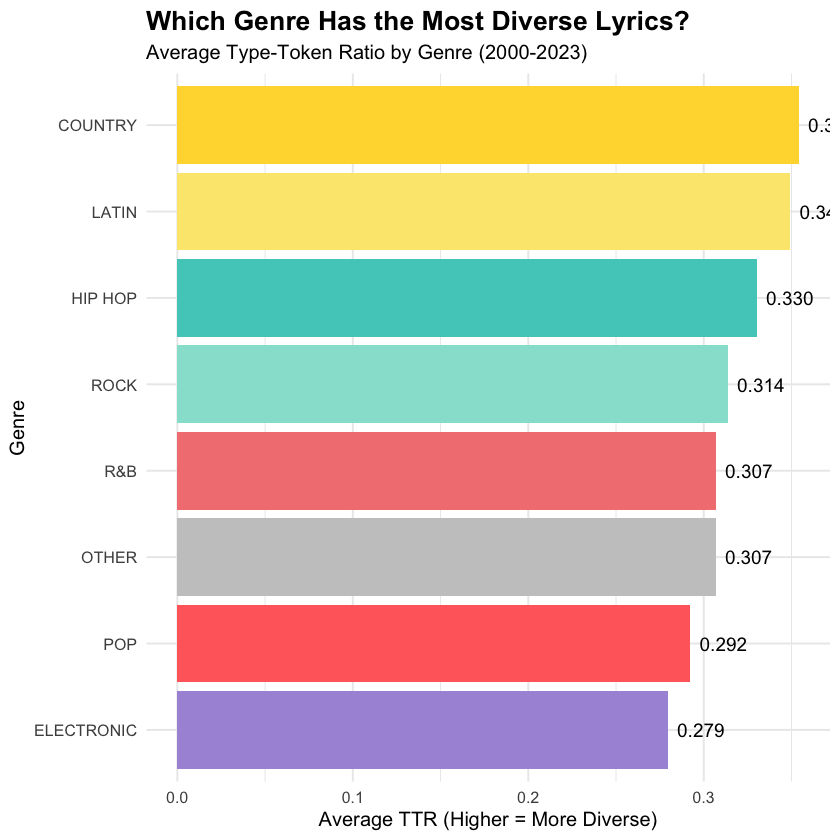

In [81]:
# Genre rankings bar chart
genre_rankings <- df_analysis %>%
  group_by(macro_genre) %>%
  summarise(
    n = n(),
    mean_ttr = mean(ttr, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(mean_ttr))

ggplot(genre_rankings, aes(x = reorder(macro_genre, mean_ttr), 
                           y = mean_ttr, 
                           fill = macro_genre)) +
  geom_col() +
  geom_text(aes(label = sprintf("%.3f", mean_ttr)), hjust = -0.2, size = 4) +
  scale_fill_manual(values = genre_colors) +
  labs(title = "Average TTR by Genre", x = "Genre", y = "TTR") +
  coord_flip() +
  theme(legend.position = "none")

## 4. Chart Performance

Warning message in cor.test.default(df_analysis$ttr, df_analysis$ranking, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  df_analysis$ttr and df_analysis$ranking
S = 3407678455, p-value = 0.000001586
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.09021476 


`geom_smooth()` using formula = 'y ~ x'


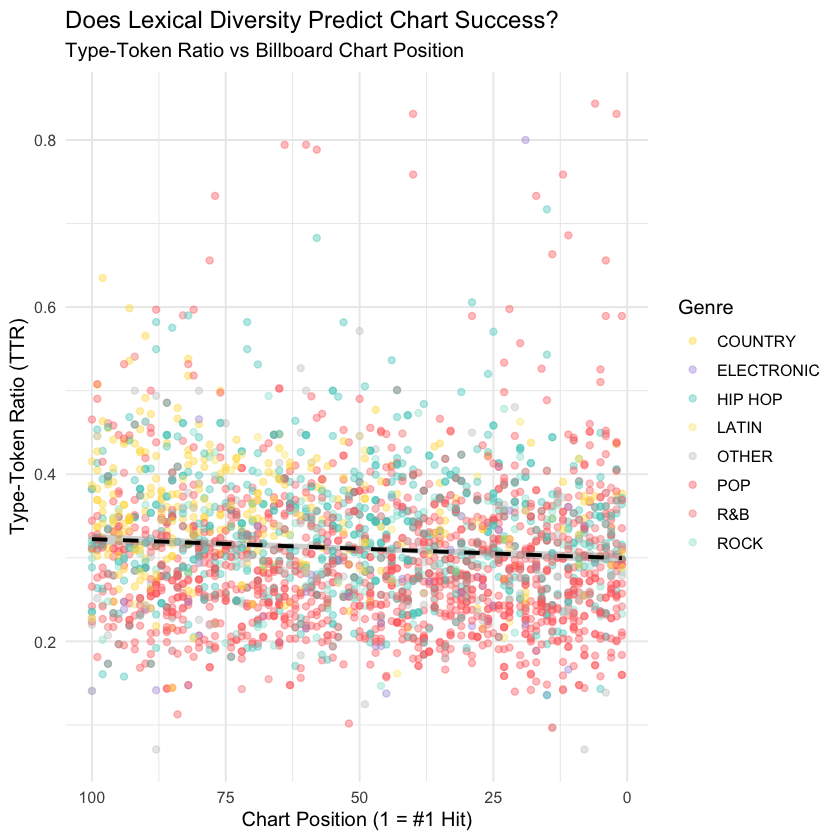

In [82]:
# TTR vs chart position correlation
cor.test(df_analysis$ttr, df_analysis$ranking, method = "spearman")

`geom_smooth()` using formula = 'y ~ x'


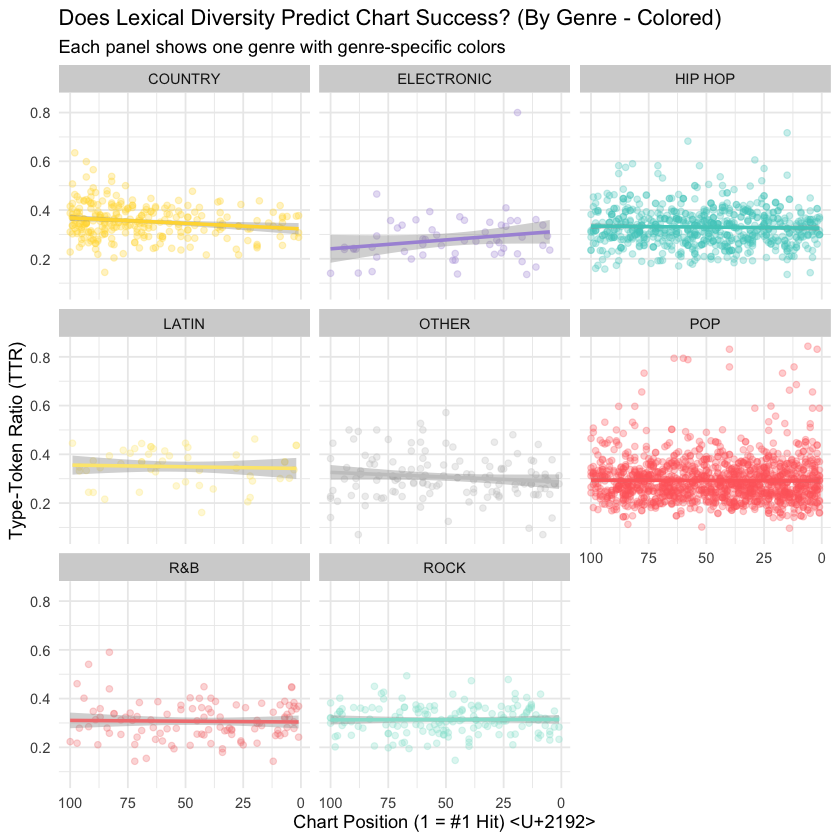

In [83]:
# TTR vs ranking scatter by genre
ggplot(df_analysis, aes(x = ranking, y = ttr, color = macro_genre)) +
  geom_point(alpha = 0.3, size = 1.5) +
  geom_smooth(method = "lm", se = FALSE, linewidth = 0.8) +
  scale_color_manual(values = genre_colors) +
  facet_wrap(~macro_genre, ncol = 3) +
  labs(title = "TTR vs Chart Position by Genre", x = "Chart Position", y = "TTR") +
  theme(legend.position = "none")

Warning message in cor.test.default(df_analysis$rare_word_ratio, df_analysis$ranking, :
"Cannot compute exact p-value with ties"


Rare Word Ratio vs Ranking: rho = -0.003, p = 0.8717


`geom_smooth()` using formula = 'y ~ x'


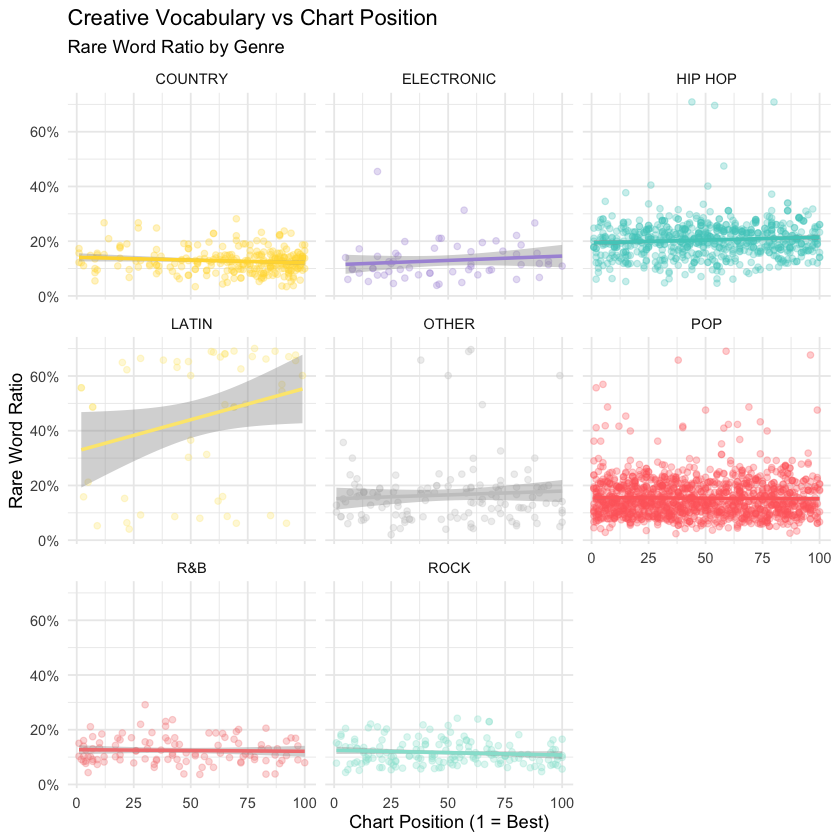

In [ ]:
# Rare word ratio vs chart position
#cambiar eje chart
cor_rare <- cor.test(df_analysis$rare_word_ratio, df_analysis$ranking, method = "spearman")
cat(sprintf("Rare words vs Ranking: rho = %.3f, p = %.4f\n", cor_rare$estimate, cor_rare$p.value))

ggplot(df_analysis, aes(x = ranking, y = rare_word_ratio, color = macro_genre)) +
  geom_point(alpha = 0.3, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE, linewidth = 1) +
  scale_color_manual(values = genre_colors) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(~macro_genre, ncol = 3) +
  labs(title = "Rare Word Ratio vs Chart Position", x = "Chart Position", y = "Rare Word Ratio") +
  theme(legend.position = "none")

### Compression Ratio

Compression Ratio = gzip compressed size / original size

- Lower = more repetitive (compresses better)
- Higher = less repetitive

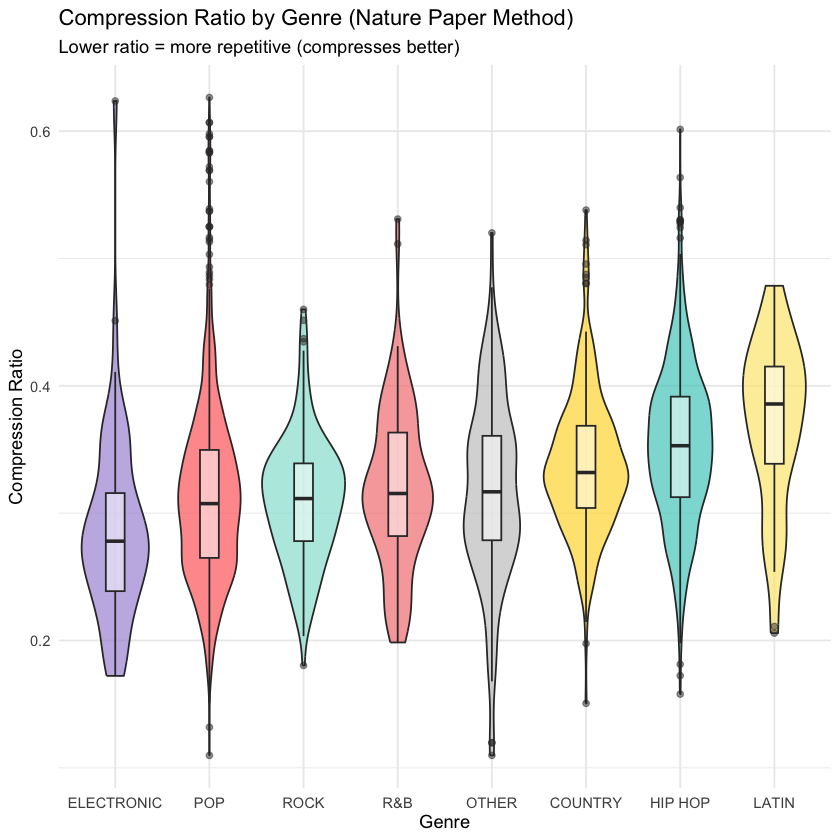

In [88]:
# Compression ratio by genre
ggplot(df_analysis, aes(x = reorder(macro_genre, compression_ratio, median), 
                        y = compression_ratio, 
                        fill = macro_genre)) +
  geom_violin(alpha = 0.7) +
  geom_boxplot(width = 0.2, fill = "white", alpha = 0.5) +
  scale_fill_manual(values = genre_colors) +
  labs(
    title = "Compression Ratio by Genre",
    subtitle = "Lower = more repetitive",
    x = "Genre",
    y = "Compression Ratio"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

`geom_smooth()` using formula = 'y ~ x'
Warning message in cor.test.default(df_analysis$compression_ratio, df_analysis$year, :
"Cannot compute exact p-value with ties"


Compression Ratio vs Year: rho = 0.027, p = 0.1540


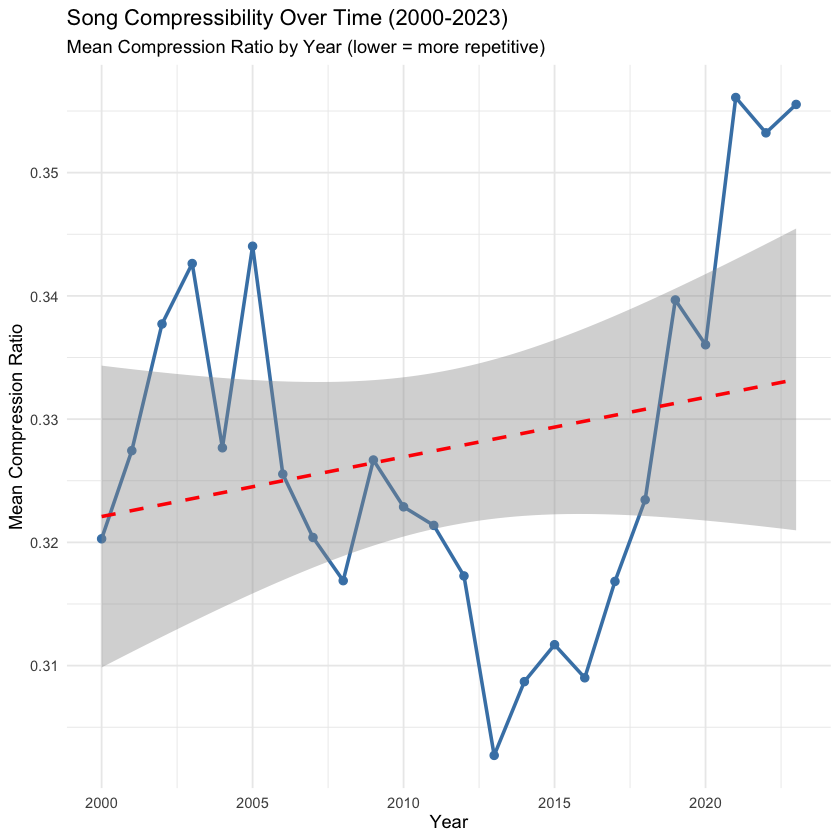

In [89]:
# Compression ratio over time
compression_trends <- df_analysis %>%
  group_by(year) %>%
  summarise(
    mean_compression = mean(compression_ratio, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(compression_trends, aes(x = year, y = mean_compression)) +
  geom_line(linewidth = 1, color = "steelblue") +
  geom_point(size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(
    title = "Compression Ratio Over Time (2000-2023)",
    x = "Year",
    y = "Mean Compression Ratio"
  ) +
  theme_minimal()

cor_compression_year <- cor.test(df_analysis$compression_ratio, df_analysis$year, method = "spearman")
cat(sprintf("Compression vs Year: rho = %.3f, p = %.4f\n", 
            cor_compression_year$estimate, cor_compression_year$p.value))

## 5. Vocabulary Uniqueness

How much do songs use common vs rare/creative words?

In [90]:
# Jaccard similarity summary
cat("Jaccard Common (overlap with 10k English words):\n")
summary(df_analysis$jaccard_common)

cat("\nRare Word Ratio (words NOT in common 10k):\n")
summary(df_analysis$rare_word_ratio)

Jaccard Common (overlap with 10k most common English words):


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0009005 0.0088982 0.0112949 0.0121963 0.0150228 0.0309421 


Rare Word Ratio (% words NOT in common 10k):


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02041 0.10791 0.15116 0.16594 0.20419 0.70874 


Vocabulary Uniqueness:


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02041 0.10791 0.15116 0.16594 0.20419 0.70874 

macro_genre n    mean_jaccard_common mean_rare_ratio mean_vocab_uniqueness
1 LATIN         51 0.008521851         0.4485687       0.4485687            
2 HIP HOP      706 0.015608671         0.2043548       0.2043548            
3 OTHER        134 0.010637386         0.1655392       0.1655392            
4 POP         1333 0.011782336         0.1537078       0.1537078            
5 ELECTRONIC    58 0.008085549         0.1289164       0.1289164            
6 COUNTRY      267 0.010076800         0.1270692       0.1270692            
7 R&B          107 0.010662512         0.1244491       0.1244491            
8 ROCK         166 0.009228939         0.1164829       0.1164829

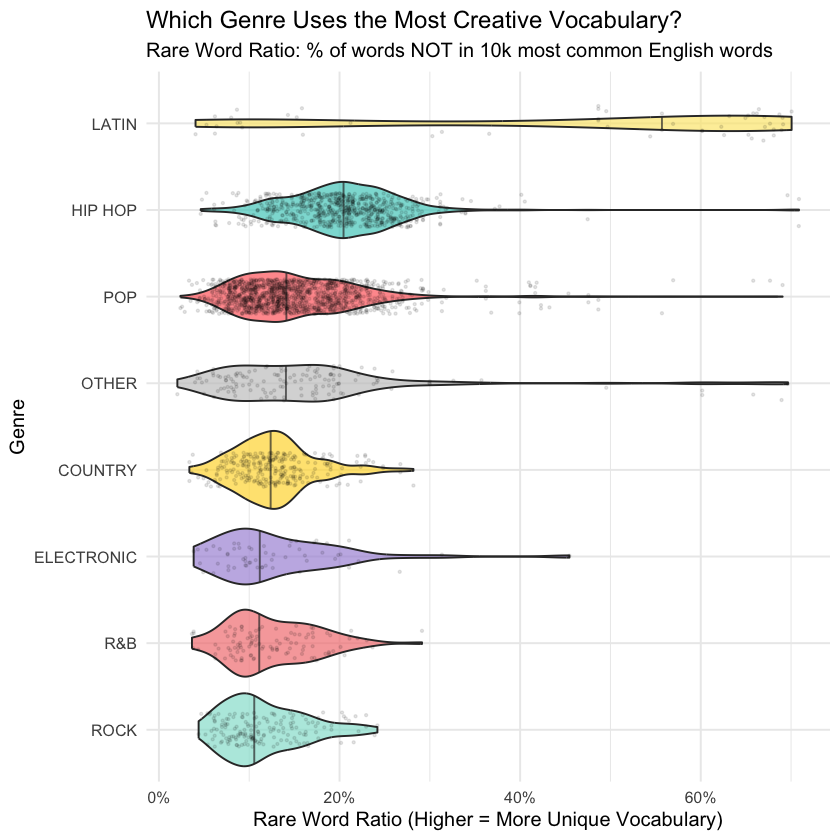

In [91]:
# Rare word ratio by genre
ggplot(df_analysis, aes(x = reorder(macro_genre, rare_word_ratio, median), 
                        y = rare_word_ratio, 
                        fill = macro_genre)) +
  geom_violin(alpha = 0.7) +
  geom_boxplot(width = 0.15, alpha = 0.8, outlier.size = 0.5) +
  scale_fill_manual(values = genre_colors) +
  scale_y_continuous(labels = percent_format()) +
  labs(title = "Rare Word Usage by Genre", x = "Genre", y = "Rare Word Ratio") +
  theme(legend.position = "none")

`geom_smooth()` using formula = 'y ~ x'


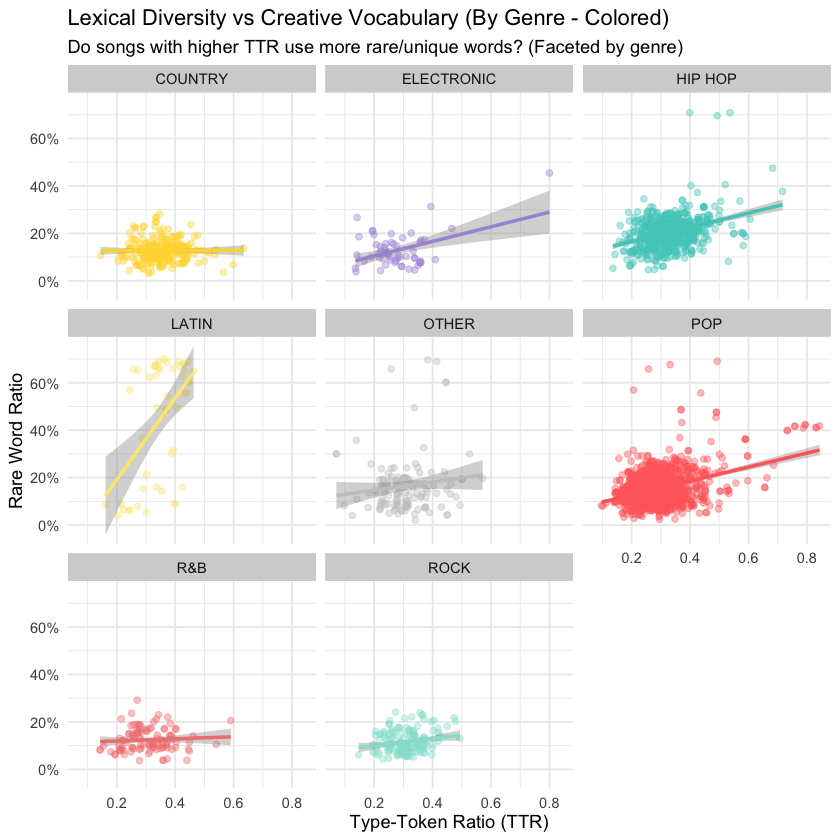

In [92]:
# TTR vs rare word ratio by genre
ggplot(df_analysis, aes(x = ttr, y = rare_word_ratio, color = macro_genre)) +
  geom_point(alpha = 0.4, size = 1) +
  geom_smooth(method = "lm", se = FALSE, linewidth = 0.8) +
  scale_color_manual(values = genre_colors) +
  facet_wrap(~macro_genre, ncol = 3) +
  scale_y_continuous(labels = percent_format()) +
  labs(title = "TTR vs Rare Word Ratio by Genre", x = "TTR", y = "Rare Word Ratio") +
  theme(legend.position = "none")

`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  df_analysis$ttr and df_analysis$rare_word_ratio
t = 16.284, df = 2820, p-value < 0.00000000000000022
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2590705 0.3265320
sample estimates:
      cor 
0.2931661 


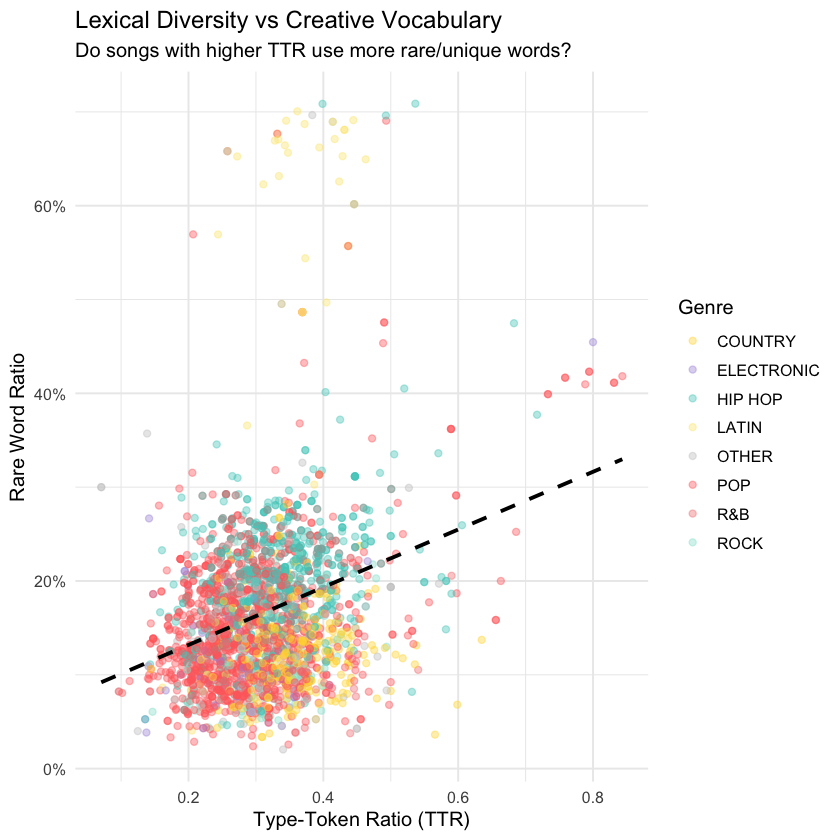

In [93]:
# TTR vs rare word ratio correlation
ggplot(df_analysis, aes(x = ttr, y = rare_word_ratio, color = macro_genre)) +
  geom_point(alpha = 0.4, size = 2) +
  geom_smooth(method = "lm", se = TRUE, color = "black", linewidth = 1) +
  scale_color_manual(values = genre_colors) +
  scale_y_continuous(labels = percent_format()) +
  labs(title = "TTR vs Rare Word Ratio", x = "TTR", y = "Rare Word Ratio") +
  theme(legend.position = "right")

cor.test(df_analysis$ttr, df_analysis$rare_word_ratio, method = "spearman")

## 6. Temporal Trends

`geom_smooth()` using formula = 'y ~ x'


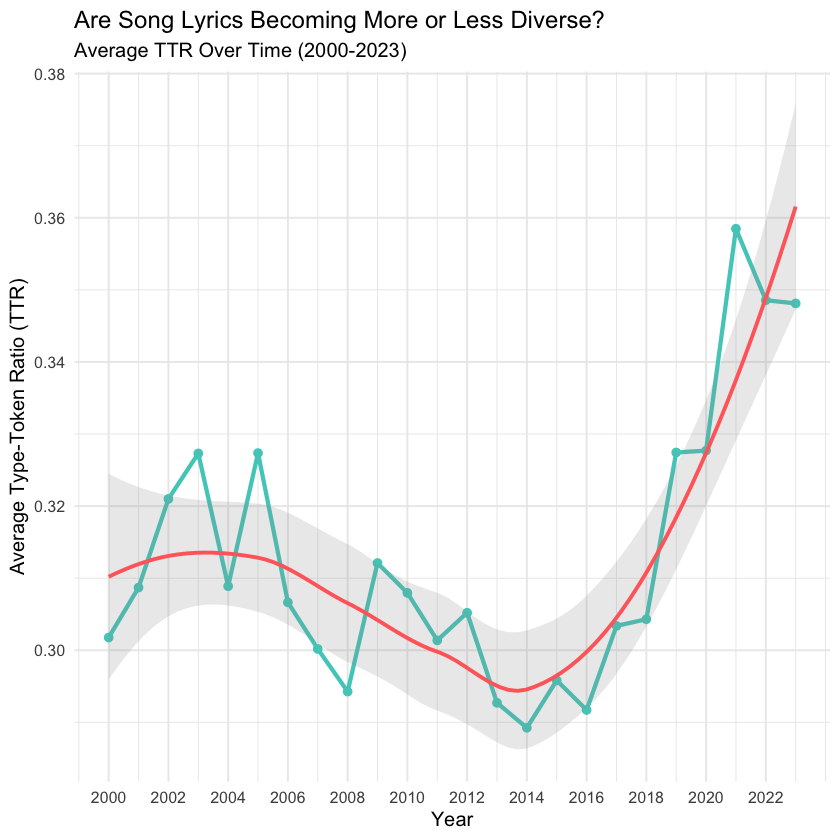

In [94]:
# TTR trends over time
yearly_trends <- df_analysis %>%
  group_by(year) %>%
  summarise(
    mean_ttr = mean(ttr, na.rm = TRUE),
    median_ttr = median(ttr, na.rm = TRUE),
    mean_rare = mean(rare_word_ratio, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(yearly_trends, aes(x = year, y = mean_ttr)) +
  geom_line(linewidth = 1, color = "steelblue") +
  geom_point(size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(title = "TTR Over Time (2000-2023)", x = "Year", y = "Mean TTR") +
  theme_minimal()

cor_ttr_year <- cor.test(df_analysis$ttr, df_analysis$year, method = "spearman")
cat(sprintf("TTR vs Year: rho = %.3f, p = %.4f\n", cor_ttr_year$estimate, cor_ttr_year$p.value))

`geom_smooth()` using formula = 'y ~ x'


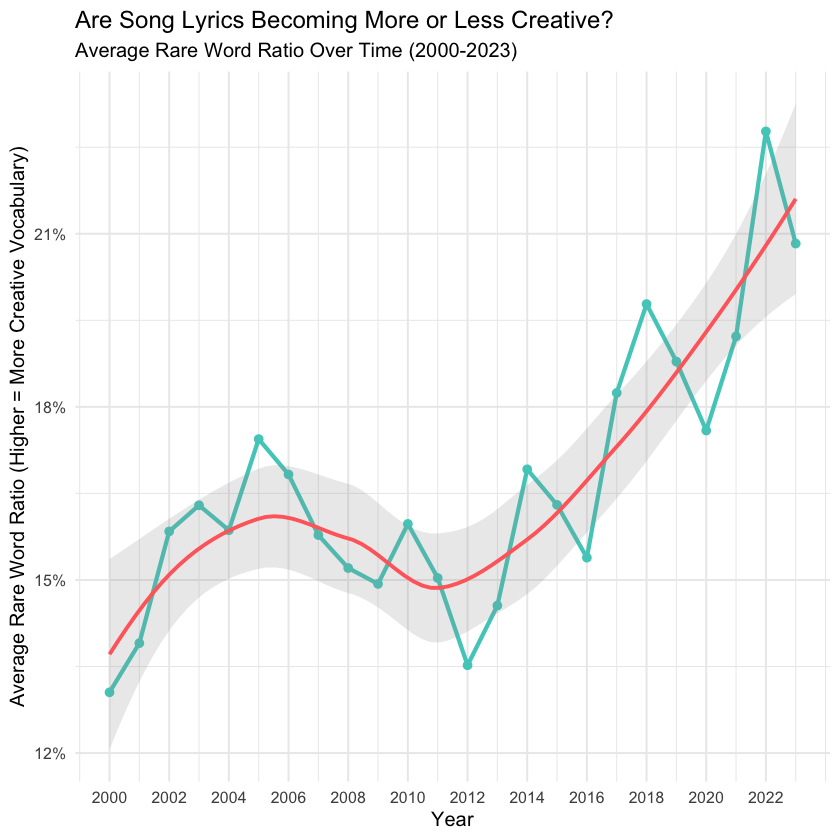

In [95]:
# Rare word ratio over time
ggplot(yearly_trends, aes(x = year, y = mean_rare)) +
  geom_line(linewidth = 1, color = "steelblue") +
  geom_point(size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  scale_y_continuous(labels = percent_format()) +
  labs(title = "Rare Word Usage Over Time", x = "Year", y = "Mean Rare Word Ratio") +
  theme_minimal()

cor_rare_year <- cor.test(df_analysis$rare_word_ratio, df_analysis$year, method = "spearman")
cat(sprintf("Rare words vs Year: rho = %.3f, p = %.4f\n", cor_rare_year$estimate, cor_rare_year$p.value))

## 7. Key Findings

In [96]:
# Most and least diverse songs
cat("=== HIGHEST TTR ===\n")
df_analysis %>%
  select(song, band_singer, year, macro_genre, ttr, total_words) %>%
  arrange(desc(ttr)) %>%
  head(10)

cat("\n=== LOWEST TTR ===\n")
df_analysis %>%
  select(song, band_singer, year, macro_genre, ttr, total_words) %>%
  arrange(ttr) %>%
  head(10)

=== MOST DIVERSE SONGS (Highest TTR) ===
# A tibble: 10 x 6
   song                   band_singer            year macro_genre   ttr ranking
   <chr>                  <chr>                 <dbl> <chr>       <dbl>   <dbl>
 1 "Calm Down"            "Selena Gomez"         2023 POP         0.843       6
 2 "Save Your Tears"      "Ariana Grande"        2021 POP         0.831       2
 3 "Save Your Tears"      "Ariana Grande"        2022 POP         0.831      40
 4 "Where Are \u00dc Now" "Jack \u00dc"          2015 ELECTRONIC  0.8        19
 5 "Essence"              "Justin Bieber"        2021 POP         0.794      60
 6 "Essence"              "Justin Bieber"        2022 POP         0.794      64
 7 "Meet Me Halfway"      "The Black Eyed Peas"  2010 POP         0.788      58
 8 "I Hope"               "Charlie Puth"         2020 POP         0.759      12
 9 "I Hope"               "Charlie Puth"         2021 POP         0.759      40
10 "Eastside"             "Halsey"               2018 POP   

macro_genre n    avg_ttr   avg_rare_words avg_jaccard_common avg_chart_pos
1 COUNTRY      267 0.3542544 0.1270692      0.010076800        69.62172     
2 LATIN         51 0.3493908 0.4485687      0.008521851        53.62745     
3 HIP HOP      706 0.3301644 0.2043548      0.015608671        51.10340     
4 ROCK         166 0.3136573 0.1164829      0.009228939        48.46988     
5 R&B          107 0.3068474 0.1244491      0.010662512        43.84112     
6 OTHER        134 0.3067347 0.1655392      0.010637386        50.16418     
7 POP         1333 0.2922730 0.1537078      0.011782336        46.18230     
8 ELECTRONIC    58 0.2794832 0.1289164      0.008085549        47.36207     
  pct_top10
1  4.868914
2 13.725490
3  8.215297
4 10.240964
5 20.560748
6 11.194030
7 12.003001
8  6.896552

## 8. Artist Vocabulary Rankings

Which artists have the largest vocabularies across their charting songs?

In [97]:
# Artist vocabulary analysis
library(tidytext)

df_full <- read_csv('../../data/cleaned/billboard_lexical_analysis_ready.csv', show_col_types = FALSE)

tokens <- df_full %>%
  filter(!is.na(lyrics)) %>%
  select(song, band_singer, year, lyrics, macro_genre) %>%
  unnest_tokens(word, lyrics) %>%
  mutate(word = str_replace_all(word, "[^a-z]", "")) %>%
  filter(word != "")

artist_vocab <- tokens %>%
  group_by(band_singer) %>%
  summarise(
    total_words = n(),
    unique_words = n_distinct(word),
    songs = n_distinct(song),
    .groups = "drop"
  ) %>%
  filter(songs >= 5) %>%
  arrange(desc(unique_words))

cat(sprintf("Artists with 5+ songs: %d\n", nrow(artist_vocab)))
head(artist_vocab, 20)

Artists analyzed: 566
Range: 30 - 3649 unique words

=== TOP 20 ARTISTS BY VOCABULARY SIZE ===
# A tibble: 20 x 4
   band_singer           macro_genre unique_words total_words
   <chr>                 <chr>              <int>       <int>
 1 "Drake"               HIP HOP             3649       42094
 2 "Destiny's Child"     POP                 3012       27227
 3 "Lil Wayne"           HIP HOP             2922       23768
 4 "Kanye West"          HIP HOP             2582       16508
 5 "Eminem"              HIP HOP             2526       18268
 6 "Nicki Minaj"         POP                 2347       21042
 7 "The Black Eyed Peas" POP                 2296        8233
 8 "Ludacris"            HIP HOP             2214       19127
 9 "Camila Cabello"      POP                 2123        7758
10 "Rihanna"             POP                 2020       23267
11 "Chris Brown"         POP                 1869       23770
12 "Bad Bunny"           LATIN               1731        8079
13 "Cardi B"      

macro_genre artists median_vocab mean_vocab max_vocab
1 LATIN        10     504.5        597.4000   1731     
2 HIP HOP     181     330.0        511.7956   3649     
3 ELECTRONIC   10     282.0        270.0000    517     
4 COUNTRY      46     280.5        345.0435    810     
5 POP         215     280.0        471.6047   3012     
6 ROCK         29     259.0        294.6897    717     
7 R&B          23     227.0        276.8261    793     
8 OTHER        52     199.5        208.4231    522

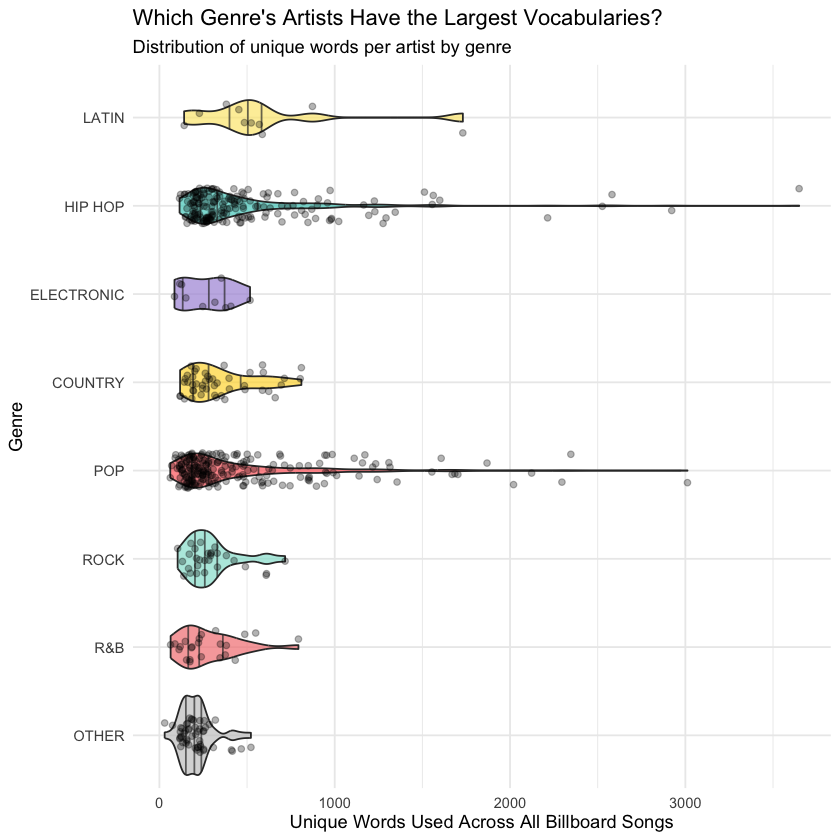

In [98]:
# Artist vocabulary distribution
ggplot(artist_vocab, aes(x = 1, y = unique_words)) +
  geom_violin(fill = "steelblue", alpha = 0.5) +
  geom_boxplot(width = 0.1) +
  labs(title = "Artist Vocabulary Size Distribution", y = "Unique Words") +
  theme_minimal() +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank())

In [99]:
# Drake vs other top artists
drake_stats <- artist_vocab %>%
  filter(str_detect(str_to_lower(band_singer), "drake"))

cat("Drake's vocabulary stats:\n")
print(drake_stats)

cat(sprintf("\nDrake's percentile: %.1f%%\n", 
            mean(artist_vocab$unique_words <= drake_stats$unique_words[1]) * 100))

=== DRAKE'S VOCABULARY STATS ===
# A tibble: 1 x 5
  band_singer macro_genre total_words unique_words  songs
  <chr>       <chr>             <int>        <int>  <dbl>
1 Drake       HIP HOP           42094         3649 0.0867

Drake's rank among HIP HOP artists: 1 out of 181

=== TOP 10 HIP HOP ARTISTS BY VOCABULARY ===
# A tibble: 10 x 3
   band_singer unique_words total_words
   <chr>              <int>       <int>
 1 Drake               3649       42094
 2 Lil Wayne           2922       23768
 3 Kanye West          2582       16508
 4 Eminem              2526       18268
 5 Ludacris            2214       19127
 6 T.I.                1599       12588
 7 Future              1562        9909
 8 Lil Baby            1556       10198
 9 50 Cent             1512       10789
10 Migos               1345        8627

=== FACTORS AFFECTING VOCABULARY SIZE ===
1. Total words analyzed: More songs = more vocabulary
2. Song style: Repetitive hooks reduce unique word count
3. Commercial success: Pop

## 9. Lexical Density

Lexical Density = Content Words / Total Words

- High: More meaningful content (nouns, verbs, adjectives)
- Low: More function words (the, a, is, and)

In [100]:
# Lexical density overview
cat("Lexical Density Summary:\n")
summary(df_analysis$lexical_density)

cat(sprintf("\nCorrelation with TTR: %.3f\n", 
            cor(df_analysis$lexical_density, df_analysis$ttr, use = "complete.obs")))

=== LEXICAL DENSITY OVERVIEW ===


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07129 0.30756 0.36200 0.37477 0.42465 0.95368 


=== BY GENRE ===
# A tibble: 8 x 5
  macro_genre     n mean_lex_density median_lex_density sd_lex_density
  <chr>       <int>            <dbl>              <dbl>          <dbl>
1 LATIN          51            0.605              0.725         0.213 
2 HIP HOP       706            0.396              0.396         0.0876
3 OTHER         134            0.394              0.366         0.136 
4 POP          1333            0.367              0.354         0.0986
5 ELECTRONIC     58            0.363              0.338         0.105 
6 COUNTRY       267            0.357              0.349         0.0721
7 R&B           107            0.329              0.328         0.0786
8 ROCK          166            0.324              0.311         0.0964

=== TTR vs LEXICAL DENSITY COMPARISON ===


macro_genre avg_ttr   avg_lex_density ttr_rank lex_density_rank
1 LATIN       0.3493908 0.6049590       1        1               
2 HIP HOP     0.3301644 0.3962332       1        1               
3 OTHER       0.3067347 0.3939360       1        1               
4 POP         0.2922730 0.3668257       1        1               
5 ELECTRONIC  0.2794832 0.3634309       1        1               
6 COUNTRY     0.3542544 0.3565842       1        1               
7 R&B         0.3068474 0.3293635       1        1               
8 ROCK        0.3136573 0.3235720       1        1

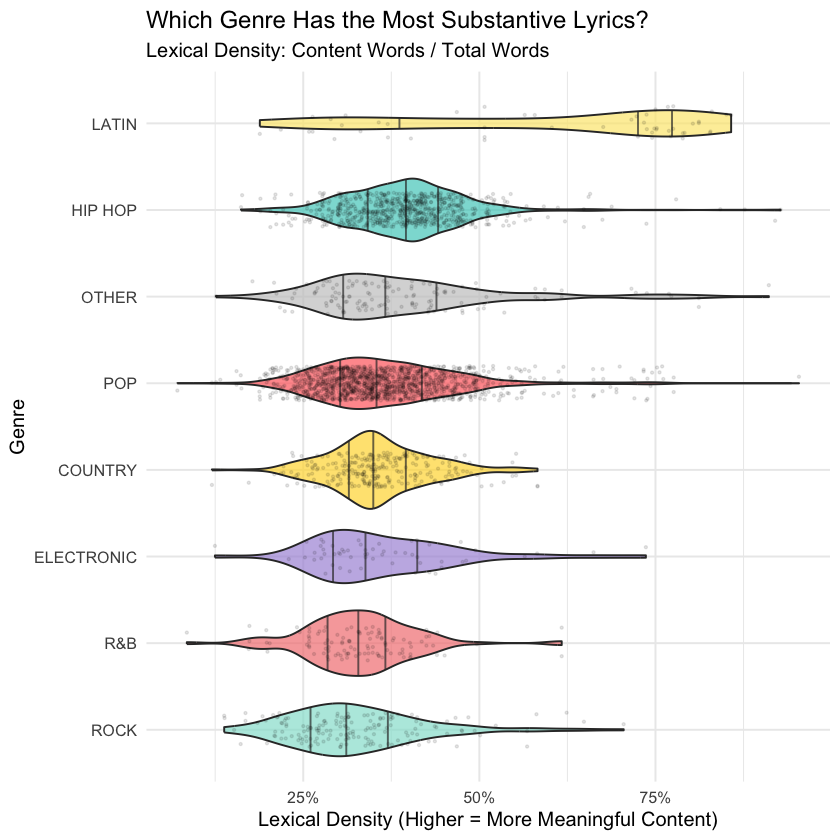

In [101]:
# Lexical density by genre
ggplot(df_analysis, aes(x = reorder(macro_genre, lexical_density, median), 
                        y = lexical_density, 
                        fill = macro_genre)) +
  geom_violin(alpha = 0.7) +
  geom_boxplot(width = 0.15, alpha = 0.8) +
  scale_fill_manual(values = genre_colors) +
  labs(title = "Lexical Density by Genre", x = "Genre", y = "Lexical Density") +
  theme(legend.position = "none")

Warning message in cor.test.default(df_analysis$lexical_density, df_analysis$ranking, :
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  df_analysis$lexical_density and df_analysis$ranking
S = 3709858134, p-value = 0.6125
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.009538545 


`geom_smooth()` using formula = 'y ~ x'


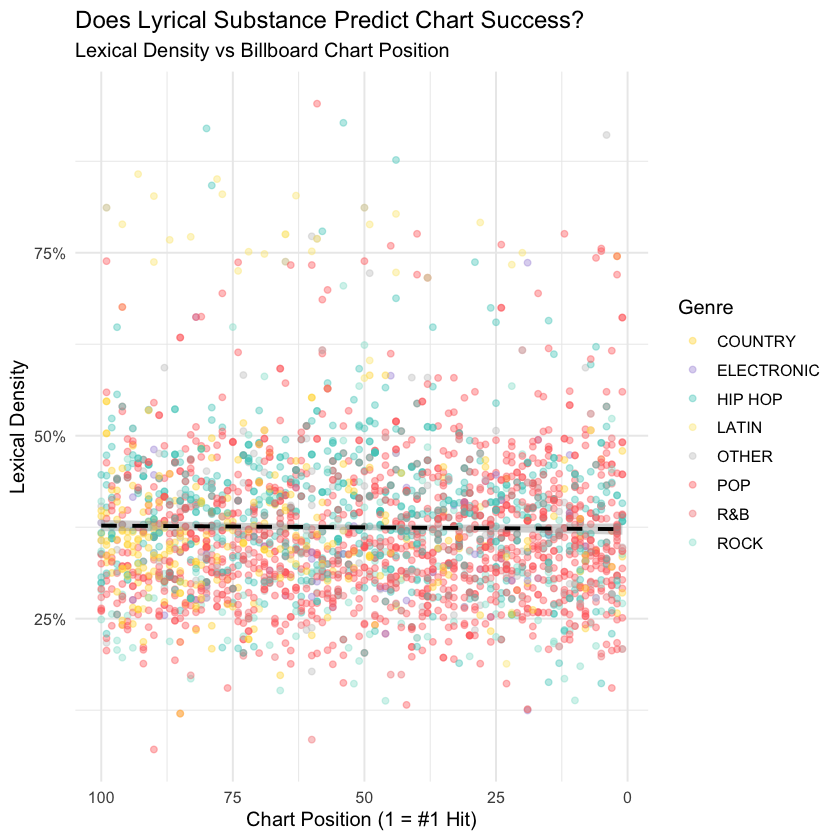

In [102]:
# Lexical density vs chart position
cor.test(df_analysis$lexical_density, df_analysis$ranking, method = "spearman")

`geom_smooth()` using formula = 'y ~ x'


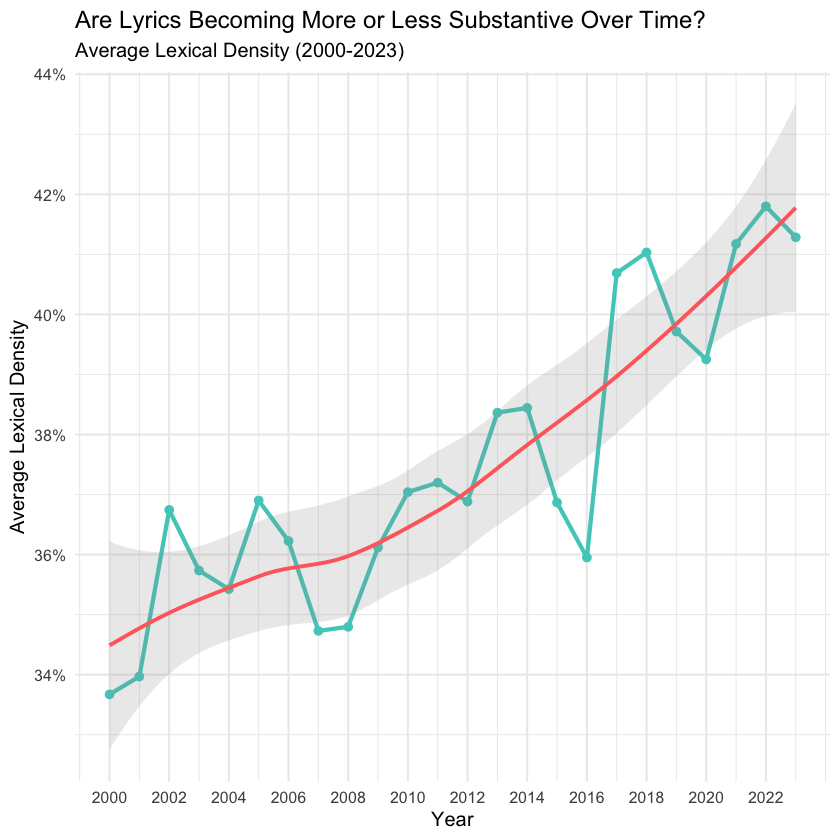

In [103]:
# Lexical density over time
lex_trends <- df_analysis %>%
  group_by(year) %>%
  summarise(mean_lex = mean(lexical_density, na.rm = TRUE), .groups = "drop")

ggplot(lex_trends, aes(x = year, y = mean_lex)) +
  geom_line(linewidth = 1, color = "steelblue") +
  geom_point(size = 2, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "red", linetype = "dashed") +
  labs(title = "Lexical Density Over Time", x = "Year", y = "Mean Lexical Density") +
  theme_minimal()

Warning message in cor.test.default(df_analysis$jaccard_genre, df_analysis$ranking, :
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(df_analysis$jaccard_corpus, df_analysis$ranking, :
"Cannot compute exact p-value with ties"


Genre-typical vs Ranking: rho = -0.019, p = 0.3214
Mainstream vs Ranking: rho = -0.017, p = 0.3651

FINDING: Neither metric predicts chart success!
Vocabulary similarity doesn't matter for hits.


`geom_smooth()` using formula = 'y ~ x'


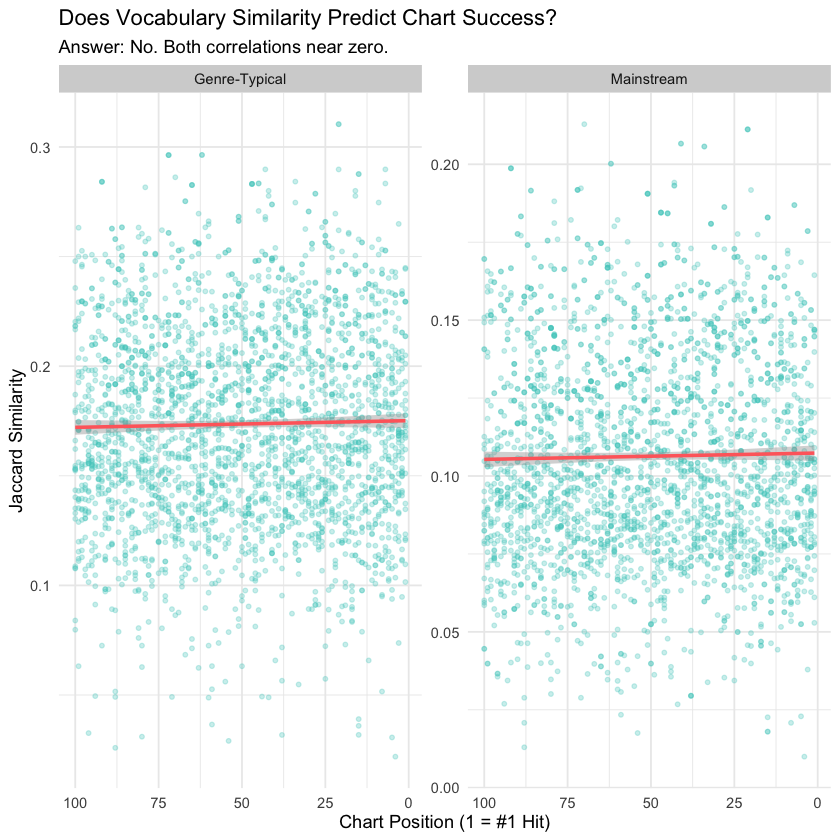

In [104]:
# Jaccard similarity vs chart position
cor_genre <- cor.test(df_analysis$jaccard_genre, df_analysis$ranking, method = "spearman")
cat(sprintf("Jaccard genre vs Ranking: rho = %.3f, p = %.4f\n", cor_genre$estimate, cor_genre$p.value))

In [105]:
# Most and least substantive songs
cat("=== HIGHEST LEXICAL DENSITY ===\n")
df_analysis %>%
  select(song, band_singer, year, macro_genre, lexical_density) %>%
  arrange(desc(lexical_density)) %>%
  head(10)

cat("\n=== LOWEST LEXICAL DENSITY ===\n")
df_analysis %>%
  select(song, band_singer, year, macro_genre, lexical_density) %>%
  arrange(lexical_density) %>%
  head(10)

=== HIGHEST LEXICAL DENSITY (Most Substantive) ===
# A tibble: 10 x 7
   song              band_singer  year macro_genre lexical_density   ttr ranking
   <chr>             <chr>       <dbl> <chr>                 <dbl> <dbl>   <dbl>
 1 "Bad"             Rihanna      2013 POP                   0.954 0.493      59
 2 "Hot Boy"         Bobby Shmu~  2014 HIP HOP               0.928 0.493      54
 3 "Thugz Mansion"   2Pac         2003 HIP HOP               0.920 0.399      80
 4 "Harlem Shake"    Baauer       2013 OTHER                 0.911 0.139       4
 5 "Locked Up"       Styles P     2004 HIP HOP               0.877 0.536      44
 6 "Dura"            Daddy Yank~  2018 LATIN                 0.857 0.333      93
 7 "Despu\u00e9s de~ Bad Bunny    2022 LATIN                 0.851 0.361      78
 8 "No More Parties" Lil Durk     2021 HIP HOP               0.842 0.425      79
 9 "Party"           Bad Bunny    2022 LATIN                 0.830 0.417      77
10 "Provenza"        Karol G      2022 

## 10. Jaccard Similarity

Measures vocabulary overlap: |A ∩ B| / |A ∪ B|

- **jaccard_genre**: How typical for genre (higher = more typical)
- **jaccard_corpus**: How mainstream (higher = common Billboard vocabulary)

# A tibble: 8 x 4
  macro_genre     n mean_jaccard_genre mean_jaccard_corpus
  <chr>       <int>              <dbl>               <dbl>
1 HIP HOP       706              0.204              0.132 
2 POP          1333              0.171              0.105 
3 R&B           107              0.167              0.0965
4 COUNTRY       267              0.155              0.0884
5 LATIN          51              0.154              0.0692
6 OTHER         134              0.148              0.0927
7 ROCK          166              0.142              0.0804
8 ELECTRONIC     58              0.132              0.0743


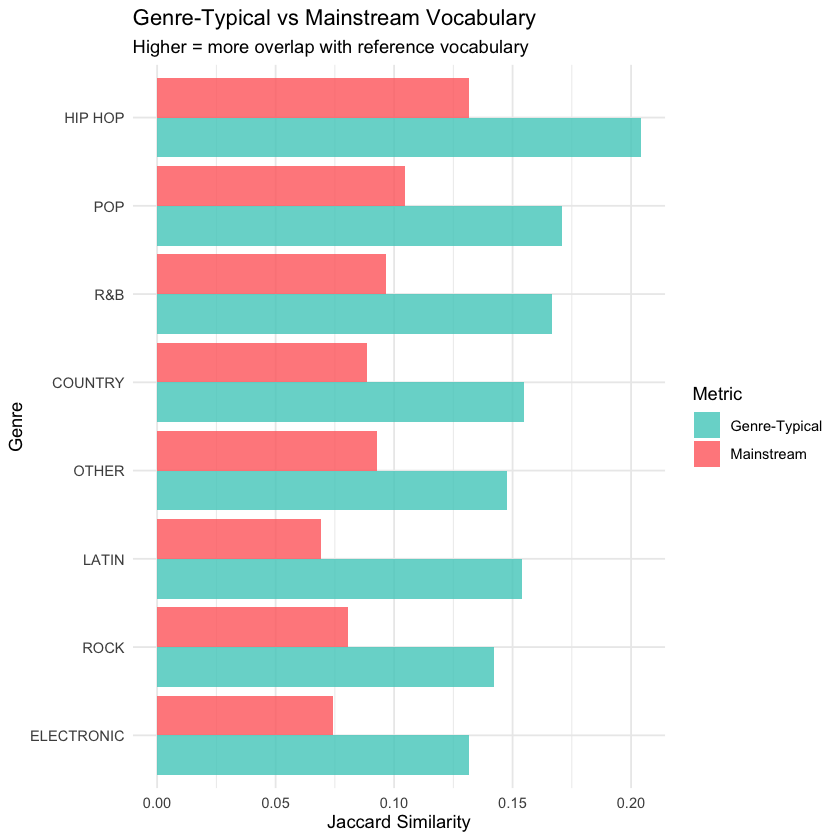

In [106]:
# Jaccard metrics by genre
jaccard_by_genre <- df_analysis %>%
  group_by(macro_genre) %>%
  summarise(
    mean_jaccard_genre = mean(jaccard_genre, na.rm = TRUE),
    mean_jaccard_corpus = mean(jaccard_corpus, na.rm = TRUE),
    .groups = "drop"
  )
print(jaccard_by_genre)

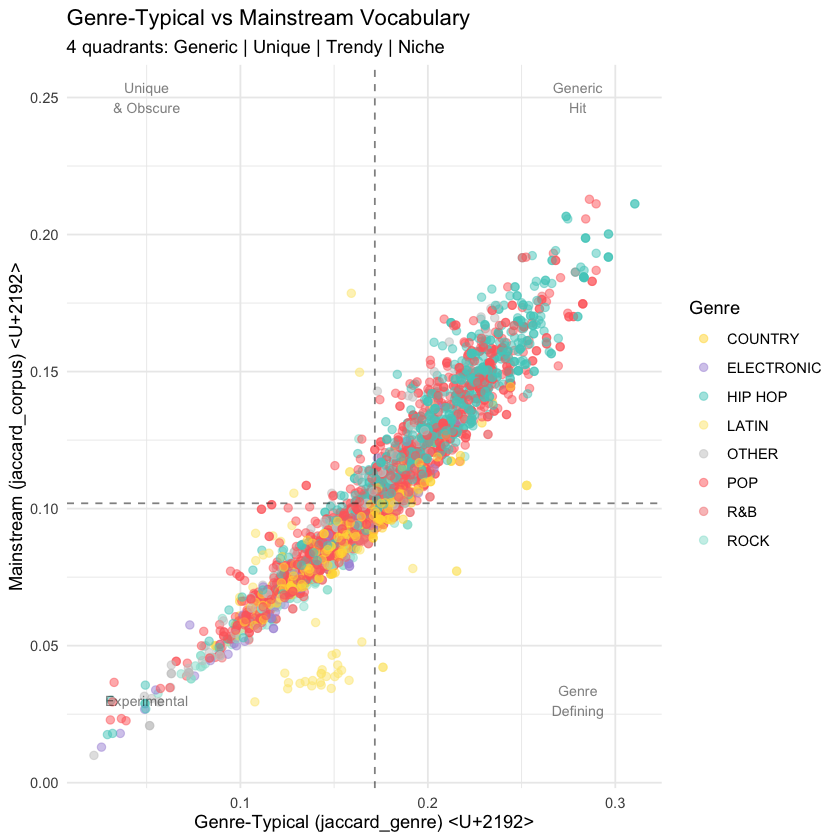

In [107]:
# Jaccard 2D space: genre-typical vs mainstream
ggplot(df_analysis, aes(x = jaccard_genre, y = jaccard_corpus, color = macro_genre)) +
  geom_point(alpha = 0.4, size = 2) +
  scale_color_manual(values = genre_colors) +
  labs(title = "Genre-Typical vs Mainstream Vocabulary", 
       x = "Jaccard Genre (genre-typical)", 
       y = "Jaccard Corpus (mainstream)") +
  theme_minimal()

Warning message in cor.test.default(df_analysis$jaccard_genre, df_analysis$ranking, :
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(df_analysis$jaccard_corpus, df_analysis$ranking, :
"Cannot compute exact p-value with ties"


Genre-typical vs Ranking: rho = -0.019, p = 0.3214
Mainstream vs Ranking: rho = -0.017, p = 0.3651

FINDING: Neither metric predicts chart success!
Vocabulary similarity doesn't matter for hits.


`geom_smooth()` using formula = 'y ~ x'


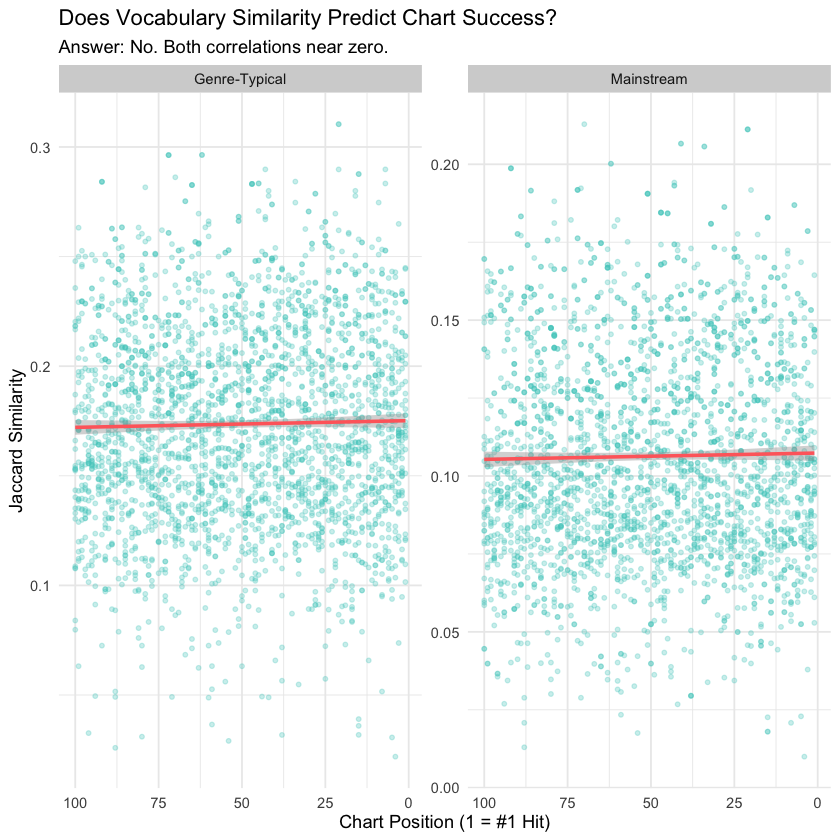

In [108]:
# Jaccard corpus vs chart position
cor_corpus <- cor.test(df_analysis$jaccard_corpus, df_analysis$ranking, method = "spearman")
cat(sprintf("Jaccard corpus vs Ranking: rho = %.3f, p = %.4f\n", cor_corpus$estimate, cor_corpus$p.value))

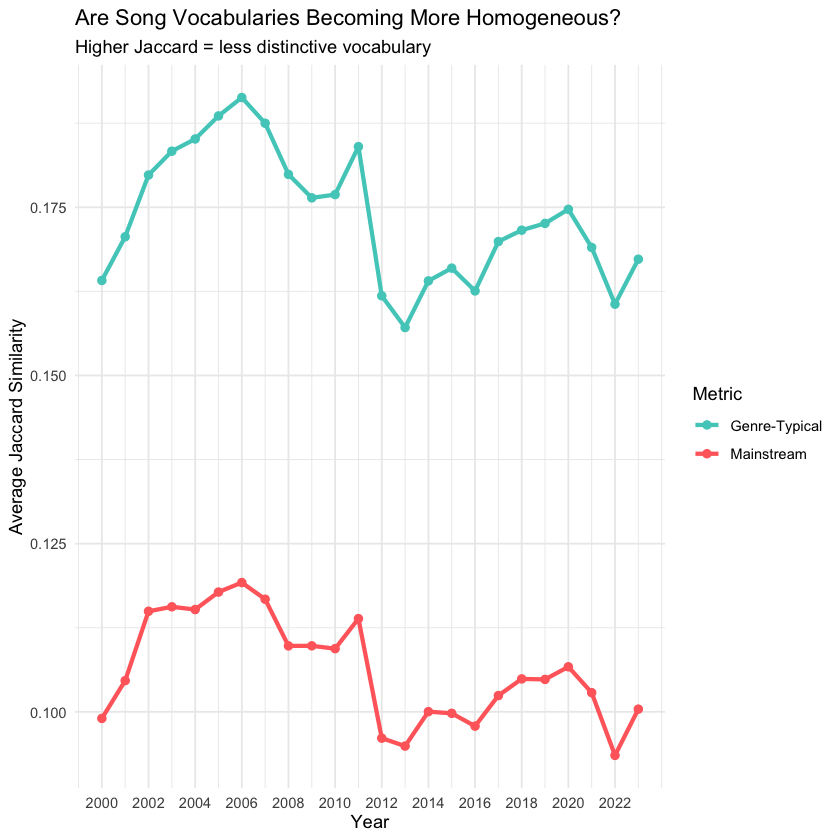

In [109]:
# Jaccard trends over time
jaccard_trends <- df_analysis %>%
  group_by(year) %>%
  summarise(
    mean_genre = mean(jaccard_genre, na.rm = TRUE),
    mean_corpus = mean(jaccard_corpus, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(jaccard_trends, aes(x = year)) +
  geom_line(aes(y = mean_genre, color = "Genre-typical"), linewidth = 1) +
  geom_line(aes(y = mean_corpus, color = "Mainstream"), linewidth = 1) +
  geom_smooth(aes(y = mean_genre), method = "lm", se = FALSE, linetype = "dashed", color = "red") +
  labs(title = "Vocabulary Homogeneity Over Time", x = "Year", y = "Mean Jaccard", color = "Metric") +
  theme_minimal()

In [110]:
# Genre outliers
cat("=== MOST GENRE-TYPICAL ===\n")
df_analysis %>%
  filter(!is.na(jaccard_genre)) %>%
  select(song, band_singer, macro_genre, jaccard_genre) %>%
  arrange(desc(jaccard_genre)) %>%
  head(10)

cat("\n=== LEAST GENRE-TYPICAL ===\n")
df_analysis %>%
  filter(!is.na(jaccard_genre)) %>%
  select(song, band_singer, macro_genre, jaccard_genre) %>%
  arrange(jaccard_genre) %>%
  head(10)

=== MOST GENRE-TYPICAL SONGS ===
# A tibble: 10 x 5
   song                 band_singer     macro_genre jaccard_genre ranking
   <chr>                <chr>           <chr>               <dbl>   <dbl>
 1 Look at Me Now       Lil Wayne       HIP HOP             0.310      21
 2 Look at Me Now       Busta Rhymes    HIP HOP             0.310      21
 3 Shake That           Eminem          HIP HOP             0.296      62
 4 Shake That           Nate Dogg       HIP HOP             0.296      62
 5 Lifestyle            Rich Gang       HIP HOP             0.296      72
 6 Lifestyle            Young Thug      HIP HOP             0.296      72
 7 Lifestyle            Rich Homie Quan HIP HOP             0.296      72
 8 Gossip Folks         Ludacris        HIP HOP             0.290      43
 9 Love the Way You Lie Rihanna         POP                 0.290       7
10 Look at Me Now       Chris Brown     POP                 0.290      21

=== LEAST GENRE-TYPICAL (Most Experimental) ===
# A tibble:

`geom_smooth()` using formula = 'y ~ x'


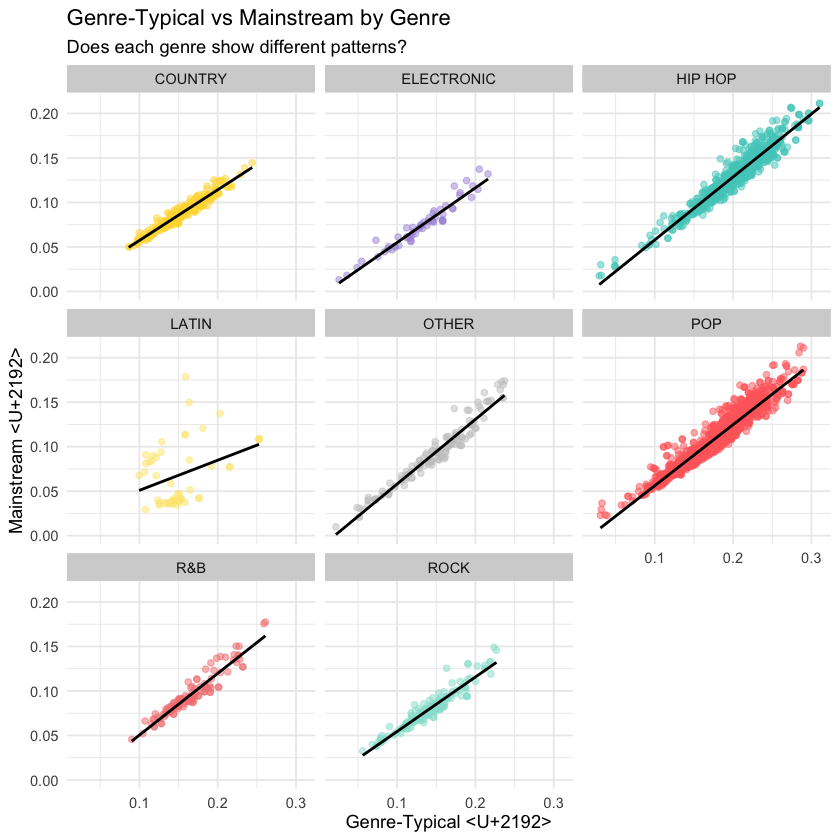

In [111]:
# Jaccard by genre faceted
ggplot(df_analysis, aes(x = jaccard_genre, y = jaccard_corpus)) +
  geom_point(aes(color = macro_genre), alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.8) +
  scale_color_manual(values = genre_colors) +
  facet_wrap(~macro_genre, ncol = 3) +
  labs(title = "Genre-Typical vs Mainstream by Genre", 
       x = "Jaccard Genre", y = "Jaccard Corpus") +
  theme(legend.position = "none")